<a href="https://colab.research.google.com/github/satyajitghana/TSAI-DeepVision-EVA4.0-Phase-2/blob/master/04-FaceRecognition-II/Train_MTCNN_LFW_Plus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! nvidia-smi

Sat Aug 22 15:58:41 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
! git clone https://github.com/timesler/facenet-pytorch && cd facenet-pytorch && git checkout dc8a1b467e47facb27c63a64410bf4a5065c7d85

Cloning into 'facenet-pytorch'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 1181 (delta 16), reused 10 (delta 2), pack-reused 1143
Receiving objects: 100% (1181/1181), 22.61 MiB | 25.05 MiB/s, done.
Resolving deltas: 100% (566/566), done.
Note: checking out 'dc8a1b467e47facb27c63a64410bf4a5065c7d85'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at dc8a1b4 Add whitespace for xs:code


Download the LFW+ Dataset that contains our 10 extra classes

In [ ]:
! gdown 'https://drive.google.com/uc?id=17k_3guDwSKclVjpyxEmgSmRvB0Z64LCq'

Downloading...
From: https://drive.google.com/uc?id=17k_3guDwSKclVjpyxEmgSmRvB0Z64LCq
To: /content/lfwplus-split-160.zip
75.2MB [00:01, 70.6MB/s]


In [ ]:
! unzip -q lfwplus-split-160.zip

In [ ]:
import sys
sys.path.insert(0, '/content/facenet-pytorch')

In [ ]:
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.nn.init import *
from torchvision import transforms, utils, datasets, models
import torchvision
from models.inception_resnet_v1 import InceptionResnetV1
import cv2
from PIL import Image
import PIL
from pdb import set_trace
import time
import copy
from pathlib import Path
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage import io, transform
from tqdm import trange, tqdm
import csv
import glob
import dlib
import pandas as pd
import numpy as np
import glob
from pathlib import Path
from torchsummary import summary
import json

## Dataset Creation

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_dir = '/content/lfwplus_split_160'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,  shuffle=True) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes
class_names

['AJ_Cook',
 'AJ_Lamas',
 'Aaron_Eckhart',
 'Aaron_Guiel',
 'Aaron_Patterson',
 'Aaron_Peirsol',
 'Aaron_Pena',
 'Aaron_Sorkin',
 'Aaron_Tippin',
 'Abba_Eban',
 'Abbas_Kiarostami',
 'Abdel_Aziz_Al-Hakim',
 'Abdel_Madi_Shabneh',
 'Abdel_Nasser_Assidi',
 'Abdoulaye_Wade',
 'Abdul_Majeed_Shobokshi',
 'Abdul_Rahman',
 'Abdulaziz_Kamilov',
 'Abdullah',
 'Abdullah_Ahmad_Badawi',
 'Abdullah_Gul',
 'Abdullah_Nasseef',
 'Abdullah_al-Attiyah',
 'Abdullatif_Sener',
 'Abel_Aguilar',
 'Abel_Pacheco',
 'Abid_Hamid_Mahmud_Al-Tikriti',
 'Abner_Martinez',
 'Abraham_Foxman',
 'Aby_Har-Even',
 'Adam_Ant',
 'Adam_Freier',
 'Adam_Herbert',
 'Adam_Kennedy',
 'Adam_Mair',
 'Adam_Rich',
 'Adam_Sandler',
 'Adam_Scott',
 'Adel_Al-Jubeir',
 'Adelina_Avila',
 'Adisai_Bodharamik',
 'Adolfo_Aguilar_Zinser',
 'Adolfo_Rodriguez_Saa',
 'Adoor_Gopalakarishnan',
 'Adrian_Annus',
 'Adrian_Fernandez',
 'Adrian_McPherson',
 'Adrian_Murrell',
 'Adrian_Nastase',
 'Adriana_Lima',
 'Adriana_Perez_Navarro',
 'Adrianna_Zuzic',
 

In [ ]:
with open('lfw_plus_classnames.json', 'w') as json_file:
  json.dump(class_names, json_file)

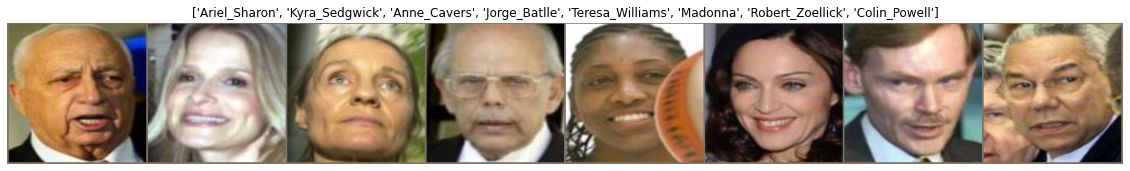

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

plt.figure(figsize=(20, 10))
plt.axis('off')
imshow(out, title=[class_names[x] for x in classes])
plt.show()

In [53]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_dir = '/content/lfwplus_split_160'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128,  shuffle=True) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}

## Create the Model for Transfer Learning

In [79]:
from models.inception_resnet_v1 import InceptionResnetV1
device = torch.device("cuda:0")
print('Running on device: {}'.format(device))
model_ft = InceptionResnetV1(pretrained='vggface2', classify=True, num_classes = len(class_names))

Running on device: cuda:0


In [80]:
layer_list = list(model_ft.children())[-5:] # all final layers
layer_list

[AdaptiveAvgPool2d(output_size=1),
 Dropout(p=0.6, inplace=False),
 Linear(in_features=1792, out_features=512, bias=False),
 BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
 Linear(in_features=512, out_features=5756, bias=True)]

In [81]:
for param in model_ft.parameters():
    param.requires_grad = False

In [82]:
model_ft.avgpool_1a = nn.AdaptiveAvgPool2d(1)
model_ft.dropout = nn.Dropout(p=0.6)
model_ft.last_linear = nn.Linear(1792, 512, bias=False)
model_ft.last_bn = nn.BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True)
model_ft.logits = nn.Linear(512, len(class_names))
model_ft = model_ft.to(device)

In [83]:
summary(model_ft, input_size=(3, 160, 160))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 79, 79]             864
       BatchNorm2d-2           [-1, 32, 79, 79]              64
              ReLU-3           [-1, 32, 79, 79]               0
       BasicConv2d-4           [-1, 32, 79, 79]               0
            Conv2d-5           [-1, 32, 77, 77]           9,216
       BatchNorm2d-6           [-1, 32, 77, 77]              64
              ReLU-7           [-1, 32, 77, 77]               0
       BasicConv2d-8           [-1, 32, 77, 77]               0
            Conv2d-9           [-1, 64, 77, 77]          18,432
      BatchNorm2d-10           [-1, 64, 77, 77]             128
             ReLU-11           [-1, 64, 77, 77]               0
      BasicConv2d-12           [-1, 64, 77, 77]               0
        MaxPool2d-13           [-1, 64, 38, 38]               0
           Conv2d-14           [-1, 80,

In [84]:
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of *gamma* every *step_size* epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=6, gamma=0.1)
onecycle_lr_scheduler = lr_scheduler.OneCycleLR(optimizer_ft, max_lr=0.2, steps_per_epoch=len(dataloaders['train']), epochs=25)

In [85]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    FT_losses = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        epoch_start = time.time()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()
                
                FT_losses.append(loss.item())
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        epoch_end = time.time()
        epoch_elapsed = epoch_end - epoch_start
        print(f'Completed Epoch {epoch} in {epoch_elapsed // 60:.0f}m {epoch_elapsed % 60:.0f}s\n')
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, FT_losses

In [86]:
model_ft, FT_losses = train_model(model_ft, criterion, optimizer_ft, onecycle_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 7.4307 Acc: 0.1499
val Loss: 6.7823 Acc: 0.1518
Completed Epoch 0 in 0m 35s

Epoch 1/24
----------
train Loss: 5.4667 Acc: 0.3139
val Loss: 5.0415 Acc: 0.2533
Completed Epoch 1 in 0m 34s

Epoch 2/24
----------
train Loss: 3.8449 Acc: 0.4396
val Loss: 2.6360 Acc: 0.5713
Completed Epoch 2 in 0m 34s

Epoch 3/24
----------
train Loss: 1.9246 Acc: 0.6577
val Loss: 0.5070 Acc: 0.9614
Completed Epoch 3 in 0m 34s

Epoch 4/24
----------
train Loss: 0.2719 Acc: 0.9845
val Loss: 0.1924 Acc: 0.9782
Completed Epoch 4 in 0m 34s

Epoch 5/24
----------
train Loss: 0.0621 Acc: 0.9945
val Loss: 0.1520 Acc: 0.9800
Completed Epoch 5 in 0m 34s

Epoch 6/24
----------
train Loss: 0.0370 Acc: 0.9970
val Loss: 0.1400 Acc: 0.9821
Completed Epoch 6 in 0m 34s

Epoch 7/24
----------
train Loss: 0.0241 Acc: 0.9983
val Loss: 0.1262 Acc: 0.9826
Completed Epoch 7 in 0m 34s

Epoch 8/24
----------
train Loss: 0.0189 Acc: 0.9985
val Loss: 0.1239 Acc: 0.9830
Completed Epoch 8 in 0m 34s

E

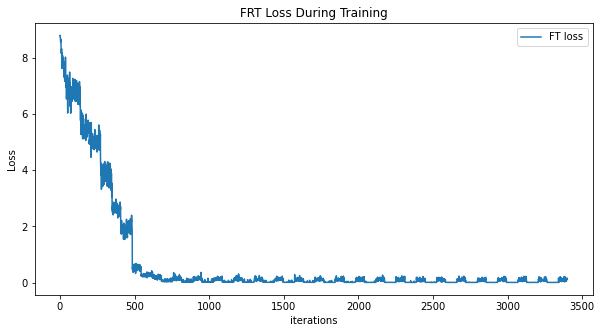

In [87]:
plt.figure(figsize=(10,5))
plt.title("FRT Loss During Training")
plt.plot(FT_losses, label="FT loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [88]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                fig = plt.figure(figsize=(10, 30))
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

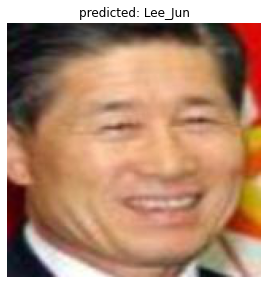

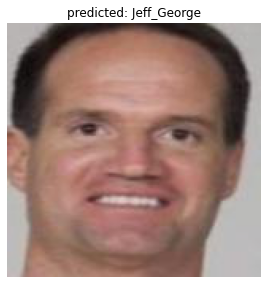

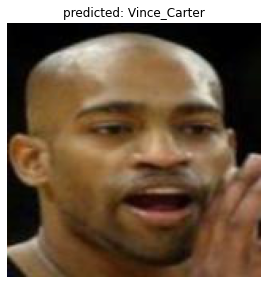

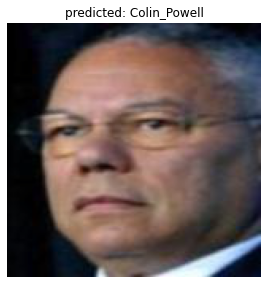

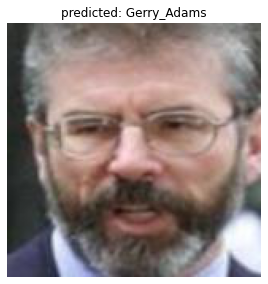

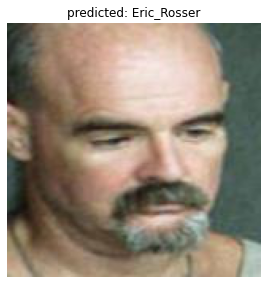

In [89]:
visualize_model(model_ft)
plt.show()

In [90]:
torch.save(model_ft, '/content/drive/My Drive/EVA4P2/04-Face-Recognition-II/lfw_plus_model.pt')

In [91]:
traced_model = torch.jit.trace(model_ft.to('cpu'), torch.randn(1, 3, 160, 160))

In [92]:
traced_model.save('/content/drive/My Drive/EVA4P2/04-Face-Recognition-II/lfw_plus_model.traced.pt')